# todo

~~zrobić wektor rhs~~

~~porządek w plikach~~

~~zamienic hardcodowane nazwy position, velocity na to co trzeba~~

predictor/corrector i zobaczyc jaka jest roznica

domyślne wartości SDE_VarIndependent

~~ścieżki~~

~~sde.rhs = ... # setter~~

czyszczenie przestrzeni nazw jako extra feature

~~warningi jesli zmienne juz istnieja w przestrzeni globalnej~~

okresowe położenie

walidacja i performance

porównanie szumów kuby i curanda

# sympy

In [53]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pickle
import collections
from IPython.display import display
from sympy.printing import ccode
from sympy import cos, Symbol, symbols, Function, init_printing, Float
import sympy
import numpy as np
import pandas as pd
from mako.template import Template
from mako.lookup import TemplateLookup
import subprocess
import six
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.tools import clear_context_caches
from pycuda.compiler import SourceModule
import numpy as np
from math import ceil
import pycuda.gpuarray as gpuarray
import logging

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1200)

class SDE_Param:
    def __init__(self, name, value):
        self.name = name
        self.value = value
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'parameter'
        if not isinstance(self.value, collections.Iterable):
            self.value = [self.value]
        new_data['values'] = np.array(self.value)
        
        data.loc[self.name] = new_data
        
class SDE_VarDependent:
    def __init__(self, name, initial_value, derivative_order):
        self.name = name
        self.initial_value = initial_value
        self.derivative_order = derivative_order
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'dependent variable'
        new_data['values'] = self.initial_value
        new_data['derivative_order'] = self.derivative_order
        
        data.loc[self.name] = new_data
        
class SDE_VarIndependent:
    def __init__(self, name, initial_value, step):
        self.name = name
        self.initial_value = initial_value
        self.step = step
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'independent variable'
        new_data['values'] = self.initial_value
        new_data['step'] = self.step
        
        data.loc[self.name] = new_data
        
class SDE_Function:
    def __init__(self, name, sympy_function):
        self.name = name
        self.s = sympy_function
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'function'

        data.loc[self.name] = new_data

class SDE_Noise:
    # https://docs.nvidia.com/cuda/curand/device-api-overview.html#distributions
    def __init__(self, name, noise_type):
        self.name = name
        self.s = Symbol(self.name)
        self.noise_type = noise_type
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'noise'
        new_data['values'] = {'noise type': self.noise_type}

        data.loc[self.name] = new_data

class bidict(dict):
    def __init__(self, *args, **kwargs):
        super(bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value,[]).append(key) 
    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value,[]).append(key)        
    def __delitem__(self, key):
        self.inverse.setdefault(self[key],[]).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(bidict, self).__delitem__(key)

class SDE:
    def __init__(self, *values):
        logging
        
        self._rhs = None
        self.rhs_string = None
        self.settings = None
        self.lookup = bidict() # maps name to data index in mako
        self.columns = ['sympy_symbol', 'type', 'values', 'step', 'derivative_order']
        self.data = pd.DataFrame(columns=self.columns, dtype='object')
        
        globals_dict = globals()
        for value in values:
            if value.name in globals_dict.keys():
                logging.warning('Value \'{}\' already defined, overwriting...'.format(value.name))
            value.fill_data(self.data)
            globals_dict[value.name] = value.s
    @property
    def rhs(self):
        return self._rhs
    @rhs.setter
    def rhs(self, value):
        self._rhs = value
    def deglobalize(self):
        globals_dict = globals()
        for name in self.data.index.values:
            del globals_dict[name]
    def solve(self, settings):
        self.settings = settings
        if self.settings.get('debug', {}).get('enabled', False):
            logging.getLogger().setLevel(logging.DEBUG)
        # self.deglobalize()
        self.rhs_string = [self.get_c_code(rhs_item) for rhs_item in self._rhs]
        logging.info('RHS: '+str(self.rhs_string))
        self.generate_cuda_code()
        self.run_cuda()
    def get_c_code(self, rhs):
        return ccode(rhs.subs(self.get_0subs())) \
            .replace('cos', 'cosf') \
            .replace('sin', 'sinf') \
            .replace('pow', 'powf')
    def get_0subs(self): # FIXME
        subs = {}
        for index, row in self.data.loc[self.data['type'] == 'parameter'].iterrows():
            subs[index] = row['values'][0]
        return subs
    def get_default_settings(self):
        return {
            'constants':{
                'steps_per_kernel_call' : 200,
                'steps_per_period' : 2000,
                'periods' : 1,                  # number of periods in the simulation
                'number_of_threads' : 4,
                'afterstep_every' : 1,
            },
            'simulation':{
                'integration_method': 'rk4',   # ['euler', 'rk4']
#                 'paths':2,#56,                # number of paths to sample
#                 'samples':100,                # sample the position every N steps
#                 'transients_number':200,      # number of periods to ignore
#                 'transients_fraction':0.1,    # fraction of periods to ignore
#                 'transients_type':'fraction', # periods to ignore because of transients (fraction, number)
#                 'rng_seed':None,
#                 'precision':'single',         # precision of the floating-point numbers (single, double)
#                 'rng_generator':'kiss32', 
#                 'deterministic':False,        # do not generate any noises
            },
            'output':{
#                 'mode':'summary',  # output mode (summary, path)
#                 'format':'text',   # output file format (text, npy)
#                 'destination':'./sde_out'
            },
            'gpu':{
                'cuda':True,
            },
            'debug':{
                'enabled':True,
            }
        }
    def generate_cuda_code(self):
        lookup = TemplateLookup(directories=['./templates'], output_encoding='utf-8', encoding_errors='replace')
        sde_template = lookup.get_template('main.mako')
        kernel_source = sde_template.render(sde=self)

        with open("./kernel.cu", 'wb') as file:
            file.write(kernel_source)

        command = 'clang-format -style=google -i ./kernel.cu'.split()
        command = 'indent -linux -sob -l120 ./kernel.cu'.split()
        print(subprocess.check_output(command).decode('utf-8'))
    def row_iterator(self, col_name, values):
        if not (isinstance(values, collections.Iterable) and not isinstance(values, six.string_types)):
            values = [values]
        return self.data.loc[self.data[col_name].isin(values)][::-1].itertuples()
    def run_cuda(self):
        mod = SourceModule(open('./kernel.cu', 'r').read(), no_extern_c=True)

        ######## randoms
        # https://stackoverflow.com/questions/46169633/how-to-generate-random-number-inside-pycuda-kernel

        init_func = mod.get_function("_Z10initkerneli")
        # fill_func = mod.get_function("_Z14randfillkernelPfi")
        seed = np.int32(123456789)
        nvalues = 1000 * 4
        init_func(seed, block=(2,2,6), grid=(1,1,1))

        ######## runs    
        # https://en.wikipedia.org/wiki/Name_mangling#How_different_compilers_mangle_the_same_functions

        gpu_summary = gpuarray.to_gpu(np.zeros((4*6)).astype(np.float32).reshape((2,2,6)))
        gpu_output = gpuarray.to_gpu(np.zeros((4*1)).astype(np.float32).reshape((2,2,1)))

        kernel_calls = ceil(sde.settings['constants']['periods'] * sde.settings['constants']['steps_per_period'] / sde.settings['constants']['steps_per_kernel_call'])
        print('kernel_calls:', kernel_calls)

        mod.get_function("prepare_simulation")(gpu_summary, gpu_output, block=(2,2,1)) # _Z18prepare_simulationPf
        for i in range(kernel_calls):
            mod.get_function("continue_simulation")(gpu_summary, gpu_output, block=(2,2,1)) # _Z19continue_simulationv
        mod.get_function("end_simulation")(gpu_summary, gpu_output, block=(2,2,1)) # _Z14end_simulationv

        summary = gpu_summary.get()
        print('out:\n', summary)

        clear_context_caches()

        print("""
        0:  position
        1:  avg_over_period_position
        2:  avg_over_periods_position
        3:  velocity
        4:  avg_over_period_velocity
        5:  avg_over_periods_velocity
        """)

# user part:

In [54]:
sde = SDE(
    SDE_Param('m', [9.931, 9.831, 9.731]),
    SDE_Param('gamma', 1.0),
    SDE_Param('a', np.linspace(5.125-1, 5.125+1, 5)),
    SDE_Param('omega', 3.749),
    SDE_Param('f', 1.0),
    SDE_Param('D', 0.0),
    SDE_Noise('xi', 'uniform'),
    SDE_VarDependent('x', 0.0, 0),
    SDE_VarDependent('v', 1.0, 1),
    SDE_VarIndependent('t', 0.0,  0.0020949113096826),
    SDE_Function('U', lambda x: sympy.cos(2*sympy.pi*x))
)
sde.rhs = [
    v,
    1.0 / m * (-gamma * v - sympy.diff(U(x), x) + a * sympy.cos(omega * t) + f + D * xi)
]
sde.solve(sde.get_default_settings())

INFO:root:RHS: ['v', '-0.100694794079146*v + 0.201389588158292*M_PI*sinf(2*M_PI*x) + 0.415366025576478*cosf(3.749*t) + 0.100694794079146']



kernel_calls: 10
out:
 [[[1.1468459 0.        1.0900918 4.569539  0.        2.2843404]
  [1.1468459 0.        1.0900918 4.569539  0.        2.2843404]]

 [[1.1468459 0.        1.0900918 4.569539  0.        2.2843404]
  [1.1468459 0.        1.0900918 4.569539  0.        2.2843404]]]

        0:  position
        1:  avg_over_period_position
        2:  avg_over_periods_position
        3:  velocity
        4:  avg_over_period_velocity
        5:  avg_over_periods_velocity
        


# sneak peeks:

data:
                                 sympy_symbol                  type                               values        step derivative_order
m                                          m             parameter                [9.931, 9.831, 9.731]        None             None
gamma                                  gamma             parameter                                [1.0]        None             None
a                                          a             parameter  [4.125, 4.625, 5.125, 5.625, 6.125]        None             None
omega                                  omega             parameter                              [3.749]        None             None
f                                          f             parameter                                [1.0]        None             None
D                                          D             parameter                                [0.0]        None             None
xi                                        xi                 n

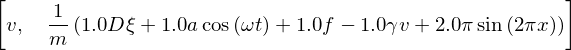



free symbols:





equation with substituted [0]values:





free symbols in equation with substituted [0]values:



In [30]:
print('data:\n', sde.data)

import pprint
print('\n\ndefault settings:\n')
pprint.pprint(sde.get_default_settings())

init_printing()
print('\n\nequation:\n')
display(sde.rhs)
print('\n\nfree symbols:\n')
display(list(eq.free_symbols for eq in sde.rhs))
print('\n\nequation with substituted [0]values:\n')
display(list(eq.subs(sde.get_0subs()) for eq in sde.rhs))
print('\n\nfree symbols in equation with substituted [0]values:\n')
display(list(eq.subs(sde.get_0subs()).free_symbols for eq in sde.rhs))
# display(rhs.subs(Value.subs_uneval()))

# testy

### 1

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def f(z, t):
    x, v = z
    dzdt = [v, -9.8125]
    return dzdt

z0 = [0, 10*np.sin(np.pi/4)]
t = [0.001*x for x in range(2000)]

sol = odeint(f, z0, t)

plt.plot(sol[:, 0], 'r')
plt.plot(sol[:, 1], 'g')
plt.show()

print(sol)
print(np.mean(np.array(sol), axis=0))

In [ ]:
import pprint

sde = SDE(
    SDE_Param('m', 1.0),
    SDE_Param('f', 9.8125),
    SDE_VarDependent('position', 0.0, 0),
    SDE_VarDependent('velocity', 10*np.sin(np.pi/4), 1),
    SDE_VarIndependent('t', 0.0, 0.001),
)
rhs = [velocity, -f/m]
settings = sde.get_default_settings()
pprint.pprint(settings)
sde.solve(rhs, settings)

### 2

In [ ]:
sde = SDE(
    SDE_Param('b', 0.25),
    SDE_Param('c', 5.0),
    SDE_VarDependent('position', np.pi - 0.1, 0),
    SDE_VarDependent('velocity', 0.0, 1),
    SDE_VarIndependent('t', 0.0, 0.001),
)
rhs = -b*velocity - c*sympy.sin(position)
settings = sde.get_default_settings()
settings['simulation']['steps_per_period'] = settings['simulation']['steps_per_kernel_call'] = 10000
print(settings)
sde.solve(rhs, settings)

In [ ]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm,os
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D

initial_state = [0.1, 0, 0, 1,1,1]
a = 4
time_points = np.linspace(0, 100, 10000)

def my_system(current_state, t):
    theta1, theta2, theta3, omega1, omega2, omega3 = current_state

    d2theta1_dt2 = -a*(2*theta1-theta2-theta3)
    d2theta2_dt2 = -a*(2*theta2-theta1-theta3)
    d2theta3_dt2 = -a*(2*theta3-theta1-theta2)

    return [ omega1, omega2, omega3, d2theta1_dt2, d2theta2_dt2, d2theta3_dt2]

xyz = odeint(my_system, initial_state, time_points)

theta1 = xyz[:, 0]
theta2 = xyz[:, 1]
theta3 = xyz[:, 2]

fig = plt.figure(figsize=(12, 9))
ax = fig.gca(projection='3d')
ax.xaxis.set_pane_color((1,1,1,1))
ax.yaxis.set_pane_color((1,1,1,1))
ax.zaxis.set_pane_color((1,1,1,1))
ax.plot(theta1, theta2, theta3, color='g', alpha=0.7, linewidth=0.6)
ax.set_title('plot')
plt.show()

### 3

In [ ]:
sde = SDE(
    SDE_Param('m', 0.1),
    SDE_Param('gamma', 1.0),
    SDE_Param('a', 8.55),
    SDE_Param('omega', 12.38),
    SDE_Param('f', 0.5),
    SDE_VarDependent('position', 0.0, 0),
    SDE_VarDependent('velocity', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  2*np.pi/3000),
    SDE_Function('U', lambda x: sympy.sin(2*np.pi*x))
)
rhs = [
    velocity,
    1.0 / m * (-gamma * velocity - sympy.diff(U(position), position) + a * sympy.cos(omega * t) + f)
]
settings = sde.get_default_settings()
settings['simulation']['periods'] = 1000
settings['simulation']['steps_per_period'] = 800
pprint.pprint(settings)
sde.solve(rhs, settings)

######

print('data:\n', sde.data)

init_printing()
print('\n\nequation:\n')
display(sde.rhs)
print('\n\nfree symbols:\n')
display(list(eq.free_symbols for eq in sde.rhs))
print('\n\nequation with substituted [0]values:\n')
display(list(eq.subs(sde.get_0subs()) for eq in sde.rhs))
# display(rhs.subs(Value.subs_uneval()))

# notes

In [ ]:
# generowanie liczb losowych

import numpy as np
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda import gpuarray

code = """
    #include <curand_kernel.h>

    const int nstates = %(NGENERATORS)s;
    __device__ curandState_t* states[nstates];

    __global__ void initkernel(int seed)
    {
        int tidx = threadIdx.x + blockIdx.x * blockDim.x;

        if (tidx < nstates) {
            curandState_t* s = new curandState_t;
            if (s != 0) {
                curand_init(seed, tidx, 0, s);
            }

            states[tidx] = s;
        }
    }

    __global__ void randfillkernel(float *values, int N)
    {
        int tidx = threadIdx.x + blockIdx.x * blockDim.x;

        if (tidx < nstates) {
            curandState_t s = *states[tidx];
            for(int i=tidx; i < N; i += blockDim.x * gridDim.x) {
                values[i] = curand_uniform(&s);
            }
            *states[tidx] = s;
        }
    }
"""

N = 1024
mod = SourceModule(code % { "NGENERATORS" : N }, no_extern_c=True)
init_func = mod.get_function("_Z10initkerneli")
fill_func = mod.get_function("_Z14randfillkernelPfi")

seed = np.int32(123456789)
nvalues = 10 * N
init_func(seed, block=(N,1,1), grid=(1,1,1))
gdata = gpuarray.zeros(nvalues, dtype=np.float32)
print(gdata)
fill_func(gdata, np.int32(nvalues), block=(N,1,1), grid=(1,1,1))
print(gdata)

In [ ]:
#plotly

import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

m = 0.2
g = 9.81
steps = 100

alpha = 89
v_0 = 30
f = np.array([0, -m*g]) # x, y
pos = np.zeros((steps, 2))
v = np.zeros((steps, 2))
v[0, :] = v_0 * np.cos(np.radians(alpha)), v_0 * np.sin(np.radians(alpha))
a = f/m
t = 0
dt = 0.1

last_i = 0
for i in range(steps-1):
    last_i = i
    v[i+1, :] = v[i, :] + a*dt
    pos[i+1, :] = pos[i, :] + v[i]*dt
    if pos[i+1, 1] < 0:
        break

poss = go.Scatter(
    x=pos[:last_i,0],
    y=pos[:last_i,1],
    mode = 'markers'
)

vs = go.Scatter(
    x=pos[:last_i,0],
    y=np.abs(v[:last_i,1]),
    mode = 'markers'
)

data = [poss, vs]

fig = go.Figure(data=data)

iplot(fig)

In [ ]:
# runge-kutta 4th order

# https://pl.wikipedia.org/wiki/Algorytm_Rungego-Kutty
# https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/

# predictor-corrector

# http://www.cmth.ph.ic.ac.uk/people/a.mackinnon/Lectures/compphys/node12.html